# MLB Salary Prediction

#### Some quick notes:
The purpose of this notebook is to create a machine learning model that predicts current baseball salaries based on a dataset of past salaries from 1986. From this data, we can create a ML model and then apply it to today using inflation. <br>
The original dataset was taken from: https://www.kaggle.com/datasets/mathchi/hitters-baseball-data?select=Hitters.csv <br>
The dataset is rather small so our model may not be the most accurate, but it gives us a general idea of patterns and trends we see over time. <br>
A potential limitation we see is that the walks in the dataset are likely total walks. As I'm not too familiar with baseball. In the current dataset, I found the total number of walks by adding BB and IBB. 

#### Imports of libraries and packages:

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import locale
from tabulate import tabulate
import matplotlib.pyplot as plt


In [4]:
# Import the csv
df = pd.read_csv("./Hitters.csv", index_col=False)

In [5]:
# Display the CSV
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


#### Data Cleaning, Preprocessing and Preperation

##### Label Encoding 
We convert the league, newleague and division columns from characters into numbers so we can apply machine learning models later on. Note that for league and new league A, which stands for American League evaluates to 0 and N which stands for National League Evaluates to 1. In the division column E (east) evalueates to 0 and W (west) evaluates to 1. We will later use these values in our testing. 

In [6]:
# This code uses the sklearn data encoder to convert league, new league and division columns from characters into numbers to be used for ml models 
le = LabelEncoder()

le.fit(df['League'])

df['League'] = le.transform(df['League'])

le.fit(df['Division'])

df['Division'] = le.transform(df['Division'])

le.fit(df['NewLeague'])

df['NewLeague'] = le.transform(df['NewLeague'])


In [7]:
# Display updated dataframe
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,NaN,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1


##### Remove all columns with salary not available
When developing our ml model, we shouldn't consider players with not available salaries

In [8]:
# Display the size of our dataset (num rows by num columns)
df.shape

(322, 20)

In [9]:
# find all null rows 
null_rows = df['Salary'].isnull()
print(null_rows)

0       True
1      False
2      False
3      False
4      False
       ...  
317    False
318    False
319    False
320    False
321    False
Name: Salary, Length: 322, dtype: bool


In [10]:
# total number of null rows 
print(null_rows.sum())

59


In [11]:
# remove all null rows and display updated dataset
df = df.dropna(subset=['Salary'])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0,0


In [12]:
# updated size of dataset
df.shape

(263, 20)

##### Identify and remove all outliers
We should remove outliers from our dataset as they can considerably skew our model

In [13]:
# uses z score of each row to identify the indexes of rows that contain outliers
outlierlist = []

outlierlist = []
for column in df.columns:
    z = np.abs(stats.zscore(df[column]))
    outliers = np.where(z > 3)[0]
    for outlier in outliers:
        if outlier not in outlierlist:
            outlierlist.append(outlier)
print(outlierlist)

[105, 188, 200, 54, 91, 126, 225, 248, 61, 84, 139, 140, 149, 219, 221, 252, 257, 261, 208, 223, 62, 76, 83, 172, 182]


In [14]:
# removes rows that contains outliers and displays updated dataset
df = df.reset_index(drop=True)
df = df.drop(outlierlist)
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
3,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,408,117,11,66,41,34,1,408,117,11,66,41,34,1,1,942,72,11,120.0,1
258,497,127,7,65,48,37,5,2703,806,32,379,311,138,1,0,325,9,3,700.0,1
259,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0,0,313,381,20,875.0,0
260,475,126,3,61,43,52,6,1700,433,7,217,93,146,0,1,37,113,7,385.0,0


##### Split dataset into X and y
X represents all of our inputs and y is the output. We are trying to calculate the salary of a player based on the rest of their stats

In [15]:
# y should be equal to the salary column from our dataset
y = df['Salary']
y.head()

0    475.0
1    480.0
2    500.0
3     91.5
4    750.0
Name: Salary, dtype: float64

In [16]:
# the inputs is the whole dataset without the salary column so we drop it 
X = df.drop('Salary', axis=1)
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,1
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,1
3,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,1
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,0


#### Data Exploration 

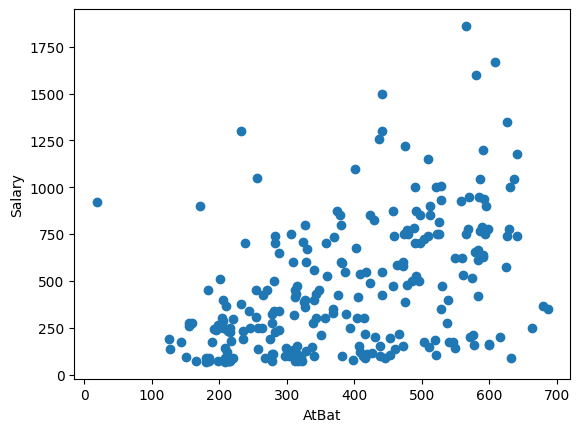

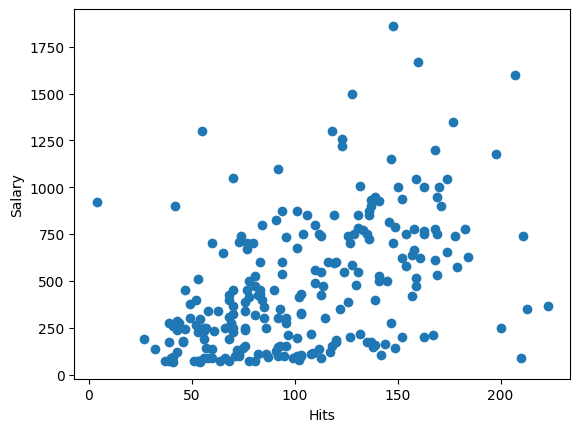

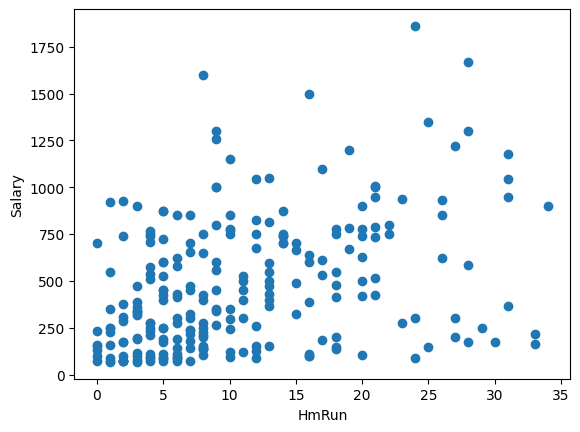

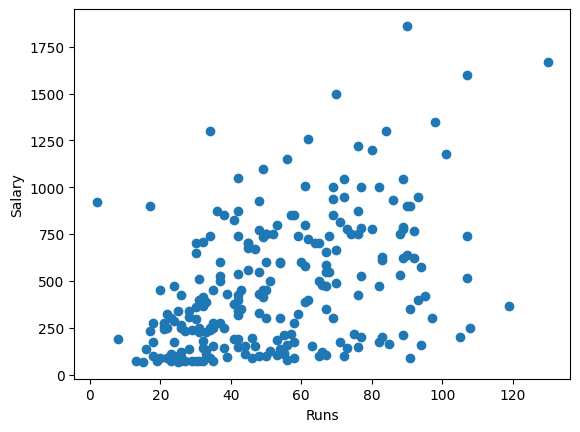

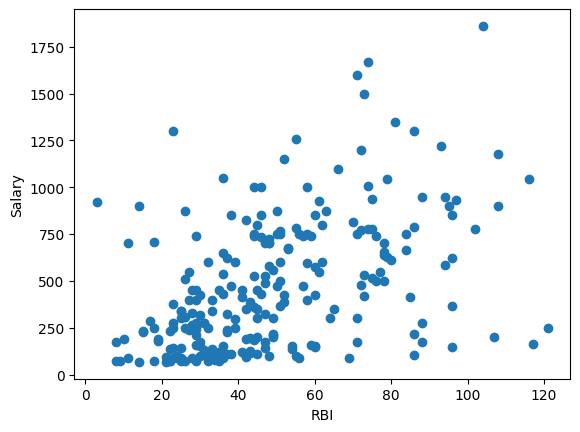

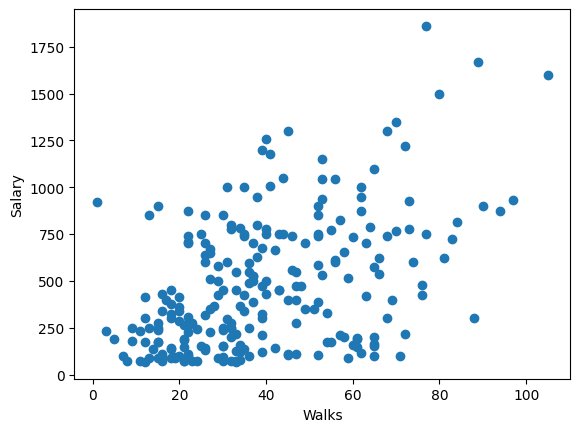

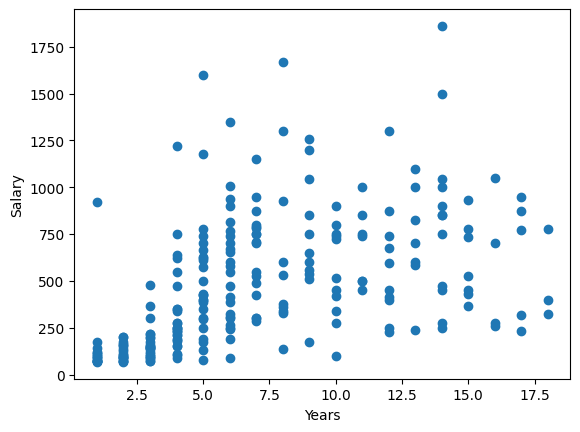

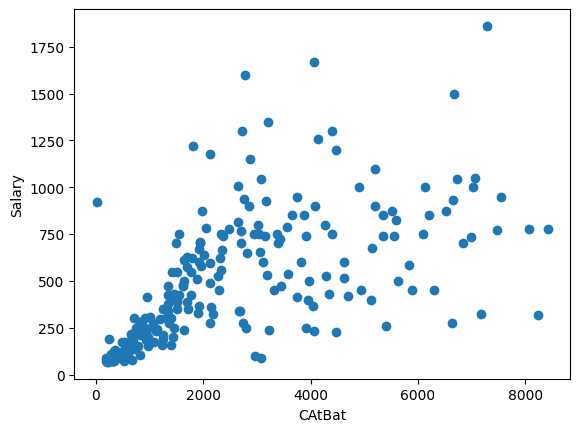

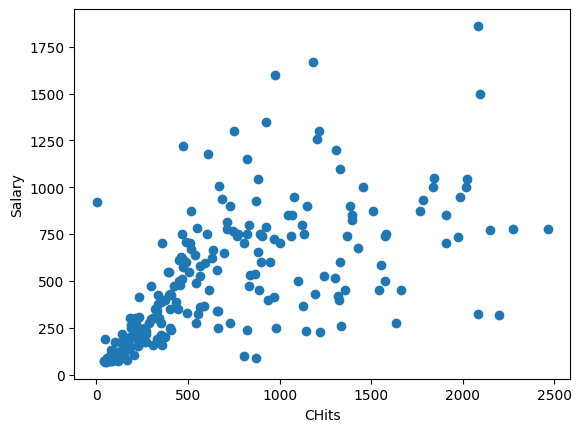

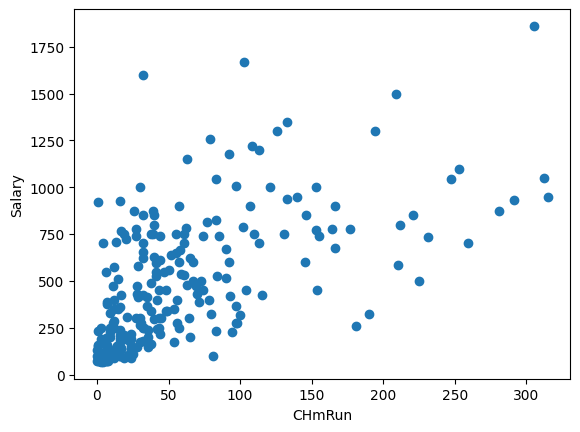

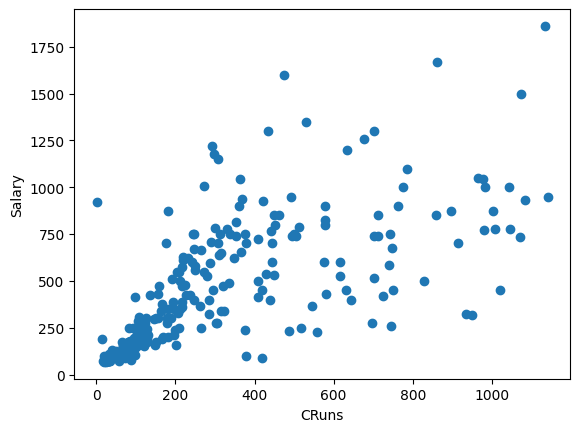

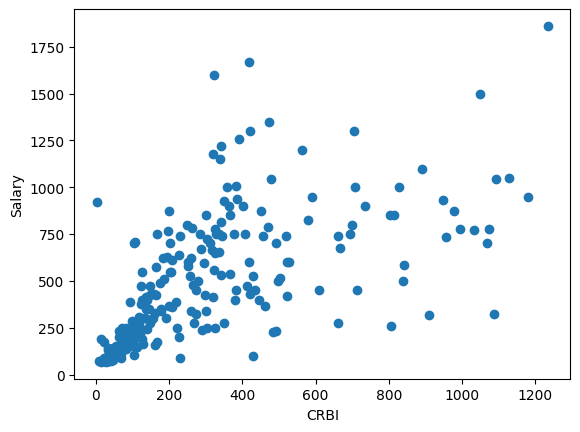

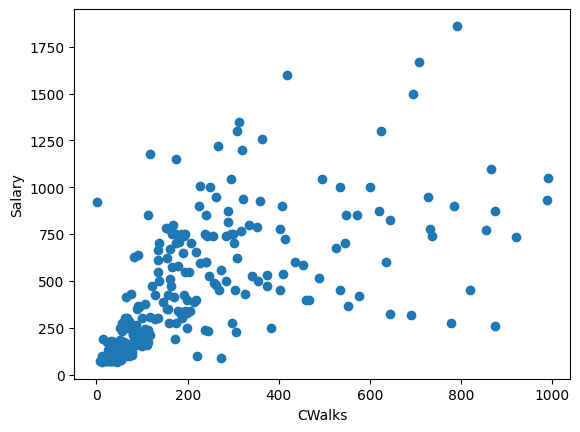

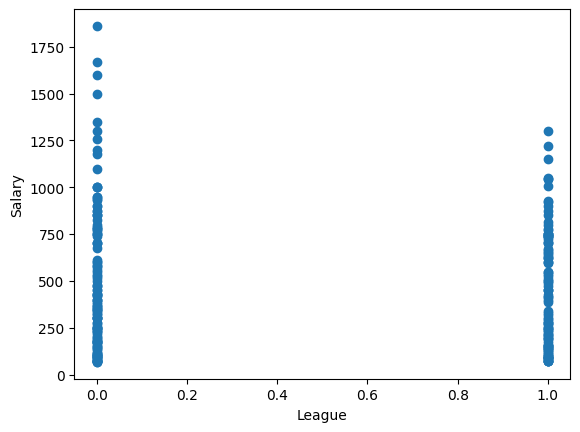

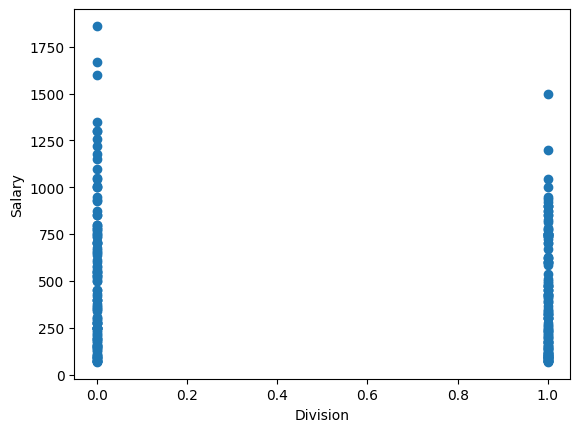

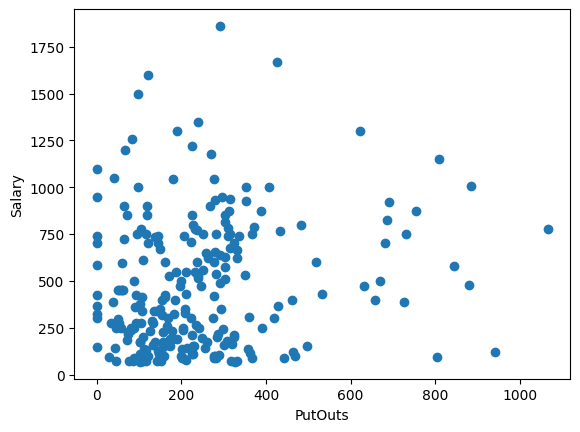

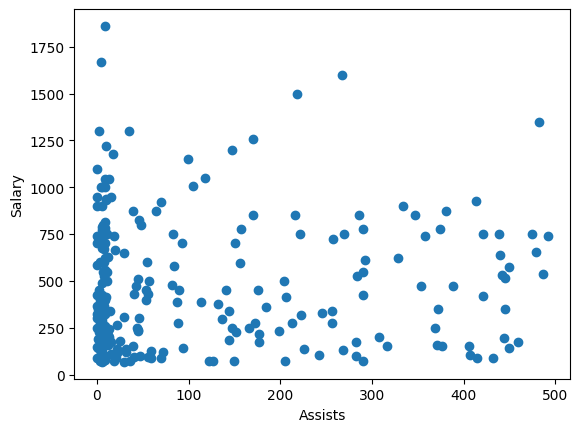

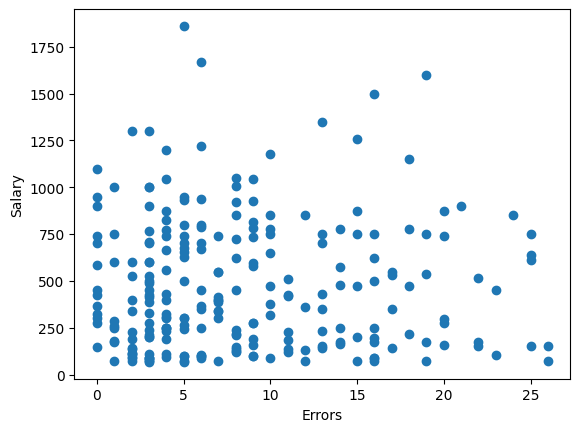

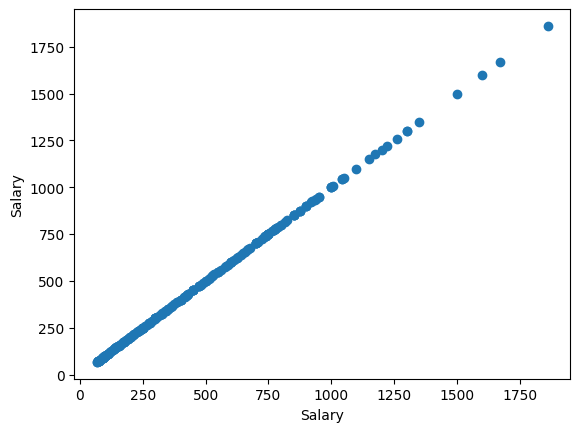

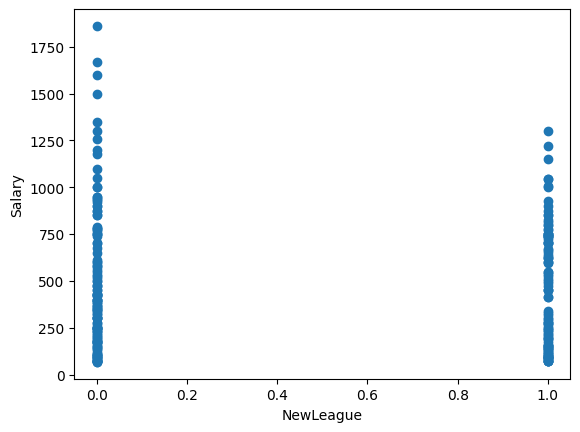

In [17]:
# create graphs to display the relationship between each of the inputs and the salary
# note that they are even though the exacts values vary a lot, there is a general positive correlation between almost all features and salaries 
# the salary is directly proportional to salary as they represent the same values 

import matplotlib.pyplot as plt


for col in df.columns[:]:  
    plt.plot(df[col], y, 'o')
    plt.xlabel(col)
    plt.ylabel('Salary')
    plt.show()

#### Model development

##### Splitting data
We must split our data into a training and testing such that we can create a model based on training data then find the generalization performance

In [18]:
# splits X and y. train consists of 70 percent of the data while test contains the other 30 percent. The indexes are randomly selected
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
# display X_train
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
125,165,39,2,13,9,16,3,196,44,2,18,10,18,0,1,332,19,2,1
246,441,113,5,76,52,76,5,1546,397,17,226,149,191,0,1,160,290,11,0
162,209,56,12,22,36,19,2,216,58,12,24,37,19,1,0,201,6,3,1
5,185,37,1,23,8,21,2,214,42,1,30,9,24,1,0,76,127,7,0
57,351,97,4,55,29,39,4,1258,353,16,196,110,117,1,1,226,7,3,0


In [20]:
# display X_test
X_test.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
123,616,163,27,83,107,32,3,1437,377,65,181,227,82,0,1,110,308,15,0
15,190,46,2,24,8,15,5,479,102,5,65,23,39,0,1,102,177,16,0
233,687,213,10,91,65,27,4,1518,448,15,196,137,89,0,0,294,445,13,0
135,591,184,20,83,79,38,5,1689,462,40,219,195,82,1,1,303,12,5,1
6,298,73,0,24,24,7,3,509,108,0,41,37,12,0,1,121,283,9,0


In [21]:
# display y_train
y_train.head()

125     75.0
246    425.0
162     90.0
5       70.0
57     210.0
Name: Salary, dtype: float64

In [22]:
# display y_test
y_test.head()

123    200.0
15     175.0
233    350.0
135    630.0
6      100.0
Name: Salary, dtype: float64

##### Dimensionality reduction
We can use dimensionality reduction methods such as PCA or SVD to reduce our features/columns while maintaining a certain level of variance. In the code below I reduce to 9 components, and we maintain 96 percent of the variance. Below is just a proof of concept, however I will not employ the projected datasets as our original dataset is very small and doesn't contain many columns. As such, we would want to maintain as much of the variance as possible  

In [23]:
# use sklearn standard scaler to scale/stardize the data and then project using PCA. cumsum represents the cumulatative sum of the variance of the 9 components
pca = PCA(n_components=9)
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_train_proj_sklearn = pca.fit_transform(X_train_std)

X_test_std = sc.transform(X_test)
X_test_proj_sklearn = pca.transform(X_test_std)

cum_sum_eigenvalues = np.cumsum(pca.explained_variance_)
print(pca.explained_variance_ratio_.cumsum())


[0.39339862 0.59192383 0.69415433 0.77929747 0.83255899 0.88318567
 0.91875204 0.9473015  0.96293804]


#### Models 
We emloy a variety of models to predict the continuous value, salary. In the below codes I used Linear Regression, xgboost, random forest, decision trees and adaboost. Our score is in the format of mean squared error, which calculates the mean of the difference between the predicted and actual values. We use cross validation to prevent overfitting of the data. Our chosen model will be the one with the lowest mean square error, which means that it had the closest results.

In [24]:
# Create a LinearRegression object
lr = LinearRegression()

# Use cross-validation to evaluate the model
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate the mean of the scores
mean_score = -scores.mean()

# Print the mean and standard deviation
print(f'Mean MSE: {mean_score}')


Mean MSE: 61622.722472193884


In [25]:
# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform grid search with cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Select best model based on mean squared error
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)


Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best score: 54017.82239564365


In [26]:
# Create Random Forest model
rf_model = RandomForestRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Select best model based on mean squared error
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)


Best hyperparameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 48308.887464512896


In [27]:
# Create Decision Tree model
dt_model = DecisionTreeRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt']
}

# Perform grid search with cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Select best model based on mean squared error
best_model = grid_search.best_estimator_
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)


Best hyperparameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 54518.09492282251


In [28]:
# Create AdaBoost model
ada_model = AdaBoostRegressor()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300]
}

# Perform grid search with cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(ada_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Select best model based on mean squared error
best_model = grid_search.best_estimator_
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)


Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best score: 52475.84355504939


#### Identify best model and find generalization performance
As previously stated, the best model will be the one with the lowest mean squared error. From out previous code we see the best model is Random Forest using the parameters: 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200. We can then use these parameters to find the generalization performance (how well the model performs on unseen data). The mse represent the mean squared error between y_pred which is our predicted values of X_test (new data) and the actual values. 

In [29]:
# Define parameter grid for hyperparameter tuning
params = {
    'n_estimators': 200,
    'max_depth': 7,
    'min_samples_split': 5,
    'min_samples_leaf': 4
}

# Create Random Forest model with best hyperparameters
rf_model = RandomForestRegressor(**params)

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the mean squared error on the test set
mse = mean_squared_error(y_test, y_pred)

print('MSE of model on test set:', mse)


MSE of model on test set: 40979.41281958786


Scatter plot to show difference between actual and predicted values on the test set. 

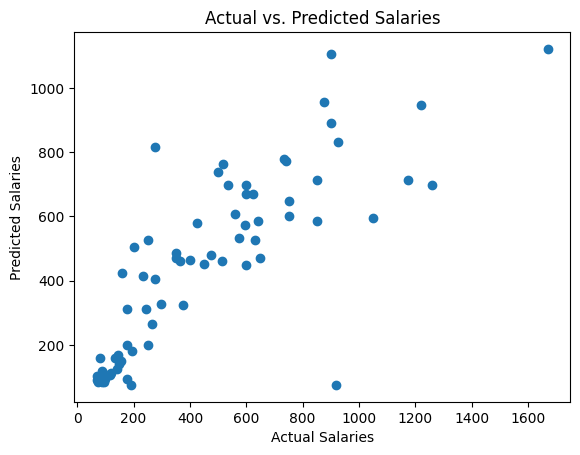

In [30]:
# Create a scatter plot
plt.scatter(y_test, y_pred)

# Add labels and title
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Actual vs. Predicted Salaries')

# Show the plot
plt.show()

#### Analysis of today's salaries


##### Creation of a test dataset
I wanted to see how salaries themselves changed overtime. To do so, I manually created a dataset. I only had 5 players, as I had manually find the statistics from the official mlb website and insert them here. The stats are from the 2022 season and the salaries are the salaries from 2023, similar to the format of the original dataset. The stats were from 1986 and salaries from the following year. I tried to pick from a variety of teams, locations, leagues and overall performance. I'd say there is a fair yet limited representation of the league. The players, teams and actual salaries can be seen in the cell below. <br>
Note: We use the values from before to determine the League and Division. 0 is American League, 1 is National. 0 is East, 1 is west. 

In [37]:
# actual salaries gathered from spotrac.com
players = ['Aaron Judge', 'Tomás E. Nido', 'Matt Thiass', 'Miguel Vargas', 'Eugenio Suarez']
teams = ['New York Yankees', 'New York Mets', 'Los Angeles Angels', 'Los Angeles Dodgers', 'Seattle Mariners']
actual_salary = ['$40,000,000.00', '$1,600,000.00', '$740,000.00', '$722,500.00', '$11,000,000.00']

In [38]:
# create datadrame with current player stats stats
data = {'AtBat':[570, 284, 69, 47, 543], 'Hits':[177, 68, 15, 8, 128], 'HmRun':[62, 3, 2, 1, 31], 'Runs':[133, 31, 9, 4, 76], 'RBI':[131, 28, 8, 8, 87], 'Walks':[130, 14, 12, 2, 73], 'Years':[8, 7, 5, 2, 10], 'CAtBat':[2638, 691, 244, 47, 4063], 'CHits':[748, 152, 50, 8, 1015], 'CHmRun':[220, 13, 11, 1, 224], 'CRuns':[535, 13, 9, 4, 582], 'CRBI':[497, 73, 32, 8, 634], 'CWalks':[511, 35, 34, 2, 481], 'League':[0, 1, 0, 1, 0], 'Division':[0, 0, 1, 1, 1], 'PutOuts':[275, 859, 155, 44, 112], 'Assists':[6, 27, 9, 3, 226], 'Errors':[0, 5, 0, 1, 10], 'NewLeague':[0, 1, 0, 1, 0]}
current_df = pd.DataFrame(data)

In [39]:
# display df. Index 0 represents Aaron Judge, 1 represents Tomas E. Nido and so on
current_df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
0,570,177,62,133,131,130,8,2638,748,220,535,497,511,0,0,275,6,0,0
1,284,68,3,31,28,14,7,691,152,13,13,73,35,1,0,859,27,5,1
2,69,15,2,9,8,12,5,244,50,11,9,32,34,0,1,155,9,0,0
3,47,8,1,4,8,2,2,47,8,1,4,8,2,1,1,44,3,1,1
4,543,128,31,76,87,73,10,4063,1015,224,582,634,481,0,1,112,226,10,0


##### Prediction of current_df

In [40]:
# Define parameter grid for hyperparameter tuning
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 4
}

# Create Random Forest model with best hyperparameters
rf_model = RandomForestRegressor(**params)

# Fit and predict the data - we use the whole X and y as a means of retraining the dataset
rf_model.fit(X,y)
y_pred_new = rf_model.predict(current_df)

In [41]:
# display predictions - in format of 1000s of dollars in 1986
y_pred_new

array([1270.55201712,  190.98766959,  173.01016967,  211.41943156,
       1073.85233098])

In [42]:
# convert to regular usd in todays currency. To do this we multiply by 1000 and 2.67 which is the inflation ratio from 1986 to 2023
y_pred_after_inflation = y_pred_new * 1000
y_pred_after_inflation = np.round(y_pred_after_inflation * 2.67, 2)

In [43]:
# display intermediate predictions 
y_pred_after_inflation

array([3392373.89,  509937.08,  461937.15,  564489.88, 2867185.72])

In [44]:
# Convert into correct format and add to predicted_current_salaries list
predicted_current_salaries = []

# Set the locale to the United States to format numbers as dollars
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

# Loop through the array of predicted values and print them as dollar amounts
for val in y_pred_after_inflation:
    formatted_val = locale.currency(val, grouping=True)
    predicted_current_salaries.append(formatted_val)

##### Feature importance:
We can display the importance of each column in our predicted salary using the sklearn library. As we can see, the stat that most greatly impacts the prediction is the cumulative hits, then cumulative at bat and so on.

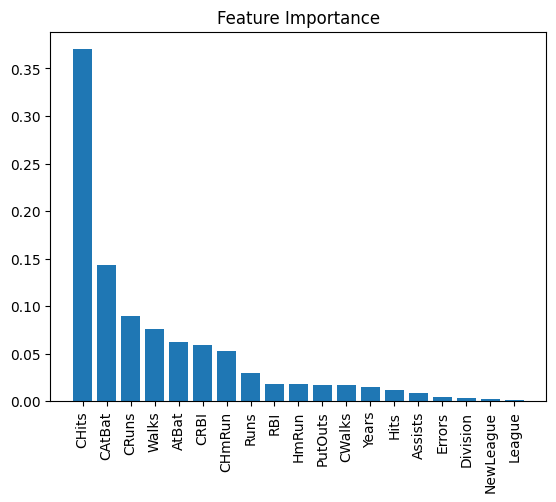

In [45]:
# Find feature importances from chosen model
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

##### Current player analysis

In [46]:
# Combine the lists into a table and print out predicted, actual and mse of salaries
table = []
actual = [0] *len(players)
predicted = [0] *len(players)

for i in range(len(players)):
    actual[i] = float(actual_salary[i].replace(',', '').replace('$', ''))
    predicted[i] = float(predicted_current_salaries[i].replace(',', '').replace('$', ''))
    mse = mean_squared_error([actual[i]], [predicted[i]])
    table.append([players[i], teams[i], predicted_current_salaries[i], actual_salary[i], mse])

# Print the table
print(tabulate(table, headers=['Player', 'Team', 'Predicted Salary', 'Actual Salary', 'MSE']))

Player          Team                 Predicted Salary    Actual Salary            MSE
--------------  -------------------  ------------------  ---------------  -----------
Aaron Judge     New York Yankees     $3,392,373.89       $40,000,000.00   1.34012e+15
Tomás E. Nido   New York Mets        $509,937.08         $1,600,000.00    1.18824e+12
Matt Thiass     Los Angeles Angels   $461,937.15         $740,000.00      7.73189e+10
Miguel Vargas   Los Angeles Dodgers  $564,489.88         $722,500.00      2.49672e+10
Eugenio Suarez  Seattle Mariners     $2,867,185.72       $11,000,000.00   6.61427e+13


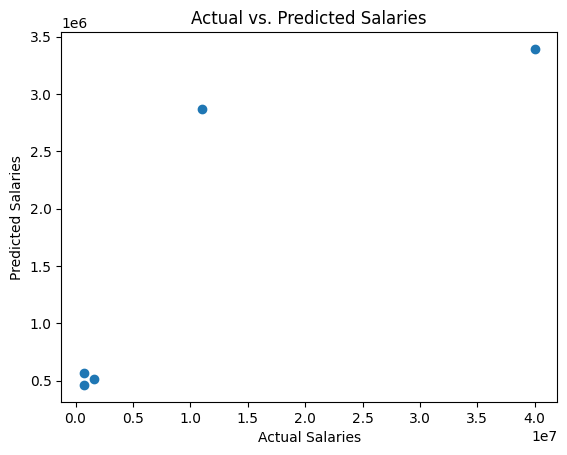

In [47]:
# Create a scatter plot
plt.scatter(actual, predicted)

# Add labels and title
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Actual vs. Predicted Salaries')

# Show the plot
plt.show()

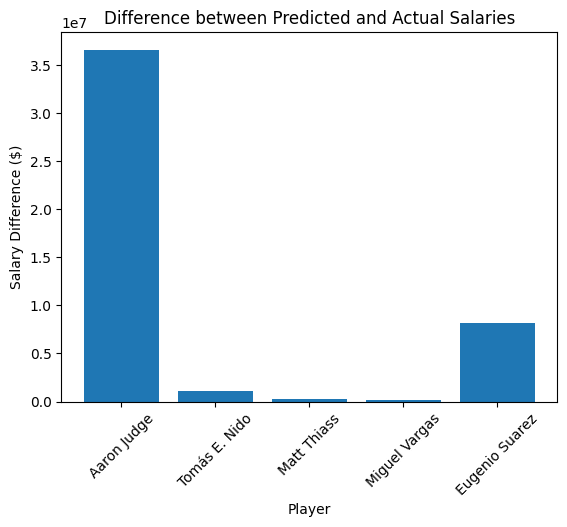

In [48]:
# Loop through to calculate the difference between the actual and predicted values
differences = [0] * len(players)
for i in range(len(players)):
    differences[i] = actual[i]-predicted[i]

# Display the players name and the differences on a bar graph
plt.bar(players, differences)
plt.xticks(rotation=45)  # rotate x-axis labels
plt.xlabel('Player')
plt.ylabel('Salary Difference ($)')
plt.title('Difference between Predicted and Actual Salaries')
plt.show()

Regardless of the persons perfromance, we see that there is a pretty significant difference, as can be seen in the large mse's. The difference is consistently in the positive direction, meaning that over time, slaries for baseball players have grown regardless of how well they did in the previous year. This could be a result of various factor, most likely the huge rise in popularity, marketing and media influence, globalization of the sport, etc.

##### Limitations and further improvements
Once again, our dataset is very limited in size and decently outdated. Our results would likely be much more accurate if our dataset was larger and perhaps if we had more years of data, not just from the start of the 1987 season. A larger dataset would ultimately result in a more accurate model.  
